# Redback Example

In this notebook we look at how we can import and use models from the [redback package](https://github.com/nikhil-sarin/redback).

Note that the bilby and redbacks packages are not installed as part of the default LightCurveLynx installation. Users will need to manually install them via pip (e.g. `pip install bilby redback`) in order to run this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from redback import model_library
from redback.priors import get_priors

from lightcurvelynx.astro_utils.passbands import PassbandGroup
from lightcurvelynx.math_nodes.np_random import NumpyRandomFunc
from lightcurvelynx.math_nodes.ra_dec_sampler import ObsTableRADECSampler
from lightcurvelynx.obstable.opsim import OpSim
from lightcurvelynx.simulate import simulate_lightcurves
from lightcurvelynx.models.redback_models import RedbackWrapperModel
from lightcurvelynx.utils.plotting import plot_lightcurves

from lightcurvelynx import _LIGHTCURVELYNX_BASE_DATA_DIR

# Reset the matplotlib configuration
plt.rcParams.update(plt.rcParamsDefault)

No module named 'lalsimulation'
lalsimulation is not installed. Some EOS based models will not work. Please use bilby eos or pass your own EOS generation class to the model
15:13 bilby INFO    : Running bilby version: 2.6.0
15:13 redback INFO    : Running redback version: 1.12.1


## Load Data Files

We start by loading the files we will need for running the simulation: the OpSim database and the passband information. Both of these live in the `data/` directory in the root directory. Note that nothing in this directory is saved to github, so the files might have to be downloaded initially.

For Rubin, a large number of OpSims can be found at [https://s3df.slac.stanford.edu/data/rubin/sim-data/](https://s3df.slac.stanford.edu/data/rubin/sim-data/). You can download an OpSim manually or using the `from_url()` helper function:

> opsim_url = "https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.4/baseline/baseline_v3.4_10yrs.db"

> opsim_data = OpSim.from_url(opsim_url)

We only care about the observations in the OpSim in the filters we wish to simulate. So we use `OpSim.filter_rows()` to remove those rows that do not match.

In [2]:
# Choose which filters to simulate.
filters = ["g", "r", "i", "z"]

# Load the OpSim data.
opsim_db = OpSim.from_db(_LIGHTCURVELYNX_BASE_DATA_DIR / "opsim" / "baseline_v3.4_10yrs.db")
print(f"Loaded OpSim with {len(opsim_db)} rows.")

# Filter to only the rows that match the filters we want to simulate.
filter_mask = np.isin(opsim_db["filter"], filters)
opsim_db = opsim_db.filter_rows(filter_mask)

# Print the number of rows and time bounds after filtering.
t_min, t_max = opsim_db.time_bounds()
print(f"Filtered OpSim to {len(opsim_db)} rows and times [{t_min}, {t_max}]")

# Load the passband data for the griz filters only.
table_dir = _LIGHTCURVELYNX_BASE_DATA_DIR / "passbands" / "LSST"
passband_group = PassbandGroup.from_preset(
    preset="LSST",
    filters=filters,
    units="nm",
    trim_quantile=0.001,
    delta_wave=1,
    table_dir=table_dir,
)

Loaded OpSim with 2146797 rows.


2025-09-17 15:14:05,224 - INFO - Loading passbands from preset LSST
2025-09-17 15:14:05,225 - INFO - Downloading data file from https://github.com/lsst/throughputs/blob/main/baseline/total_u.dat?raw=true to /Users/jkubica/h/lightcurvelynx/data/passbands/LSST/LSST/u.dat


Filtered OpSim to 1630613 rows and times [60796.00143922635, 64448.429406568604]


SHA256 hash of downloaded file: d8fb220fed913551eb1ae5744a49e145d62aa2fd97786b515f30d20e13223b37
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
2025-09-17 15:14:05,876 - INFO - Loading passband from file: /Users/jkubica/h/lightcurvelynx/data/passbands/LSST/LSST/u.dat
2025-09-17 15:14:05,888 - INFO - Downloading data file from https://github.com/lsst/throughputs/blob/main/baseline/total_g.dat?raw=true to /Users/jkubica/h/lightcurvelynx/data/passbands/LSST/LSST/g.dat
SHA256 hash of downloaded file: f8935b3a5514e436aea45895369f568bfcc57a682852b0abe3292fd754a7094f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
2025-09-17 15:14:06,387 - INFO - Loading passband from file: /Users/jkubica/h/lightcurvelynx/data/passbands/LSST/LSST/g.dat
2025-09-17 15:14:06,396 - INFO - Downloading data file from https://

## Create the model

We want to create a model that uses the predefined redback model from its library. Redback offers an extensive collection of models that can be accessed by name. For a list see [here](https://redback.readthedocs.io/en/latest/models.html). For this example, we choose the "one_component_kilonova_model" model. We look up the model using the `redback.model_library.all_models_dict` dictionary.

Note that redback models are defined as functions. All parameters, such as redshift or ejecta mass, are passed into this function as keyword arguments. As we will see shortly, TDAstro handles the conversion of sampled parameters into keyword parameters behind the scenes.

In [3]:
rb_model = model_library.all_models_dict["one_component_kilonova_model"]

Next we create a wrapper `RedbackWrapperModel` which brings the redback model into the TDAstro API space. This wrapper handles everything from the interpretation of parameters to the conversion of units (redback and TDAstro use different default units).

As in other examples, we want to make the parameters dynamic to mirror a real simulation. Let's start by drawing:

  * The location (`RA`, `dec`) uniformly from the footprint of the survey.
  * The start time (`t0`) uniformly from the coverage of the survey.
  * The `redshift` uniformly from [0.0, 0.1]
  * The mass ejecta (`mej`) as a Gaussian with mean 0.05

For the rest of the parameters we will set as constants (though these could also use samplers):

  * Gray opacity (`kappa`) = 1
  * Temperature floor in K (`temperature_floor`) = 3000
  * Minimum initial velocity (`vej`) = 0.2

**Note**: Unlike the other `PhysicalModel` classes, we will not pass all parameters as keyword arguments. The `RedbackWrapperModel` constructor takes a dictionary of parameters needed for that model. The dictionary maps parameter name to its setter.

Later in this notebook, we will see how we can instead use predfined redback priors to take advantage of their excellent library.

In [4]:
# Use an OpSim based sampler for position.
ra_dec_sampler = ObsTableRADECSampler(
    opsim_db,
    radius=3.0,  # degrees
    node_label="ra_dec_sampler",
)

# Use a uniform sampler for the starting time (t0) of activity.
time_sampler = NumpyRandomFunc("uniform", low=t_min, high=t_max, node_label="time_sampler")

# Set the parameters that are needed by the redback model. Note that the first two are set
# from samplers, while the last three are fixed values.
parameters = {
    "mej": NumpyRandomFunc("normal", loc=0.05, scale=0.02),
    "redshift": NumpyRandomFunc("uniform", low=0.0, high=0.1),
    "temperature_floor": 3000,
    "kappa": 1,
    "vej": 0.2,
}

# Create the model itself.
source = RedbackWrapperModel(
    rb_model,
    parameters=parameters,  # Set ALL the redback model parameters
    ra=ra_dec_sampler.ra,  # Set other parameters
    dec=ra_dec_sampler.dec,
    t0=time_sampler,
    node_label="source",
)

## Generate the simulations

We can now generate random simulations with all the information defined above. The `simulate_lightcurves` function takes four parameters: the source from which we want to sample (here the collection of lightcurves), the number of results to simulate (100), the opsim, and the passband information.

In [5]:
lightcurves = simulate_lightcurves(source, 100, opsim_db, passband_group)

The results are written in the [nested-pandas](https://github.com/lincc-frameworks/nested-pandas) format for easy analysis. Each row corresponds to a single simulated object, with a unique id, ra, dec, etc. The column `params` include all internal state, including hyperparameter settings, that was used to generate this object. The nested `lightcurve` column contains the times, filters, and fluxes for each observation of that object.  We can treat it as a (nested) table.

Let's look at the lightcurve for the first object sampled:

In [6]:
print(lightcurves.loc[0]["lightcurve"])

               mjd filter        flux     fluxerr  flux_perfect  survey_idx
0     60901.252775      g -389.590955  386.362789     -0.000865           0
1     60901.253191      g  -60.594176  379.755699     -0.000865           0
...            ...    ...         ...         ...           ...         ...
7079  64366.067046      g   38.352626   67.593579      8.695303           0
7080  64375.100424      z  369.577841  591.242344      3.655498           0

[7081 rows x 6 columns]


Now let's plot the first few lightcurves to see what they look like when observed via Rubin's cadence.

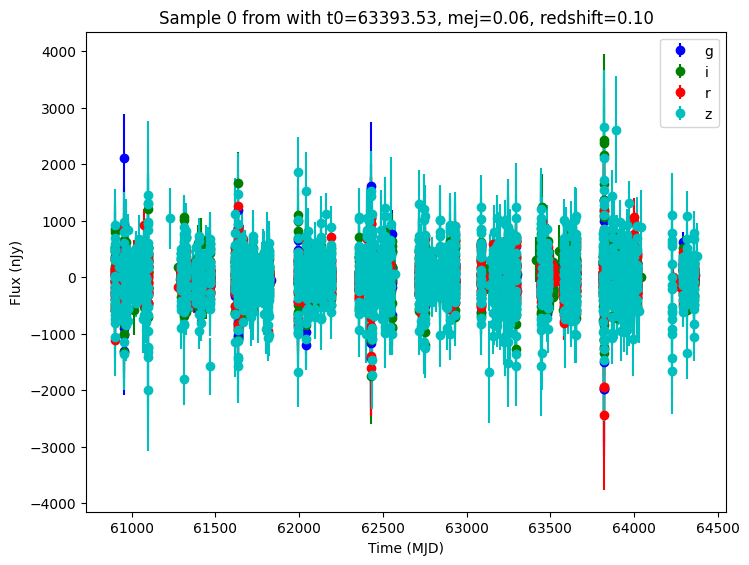

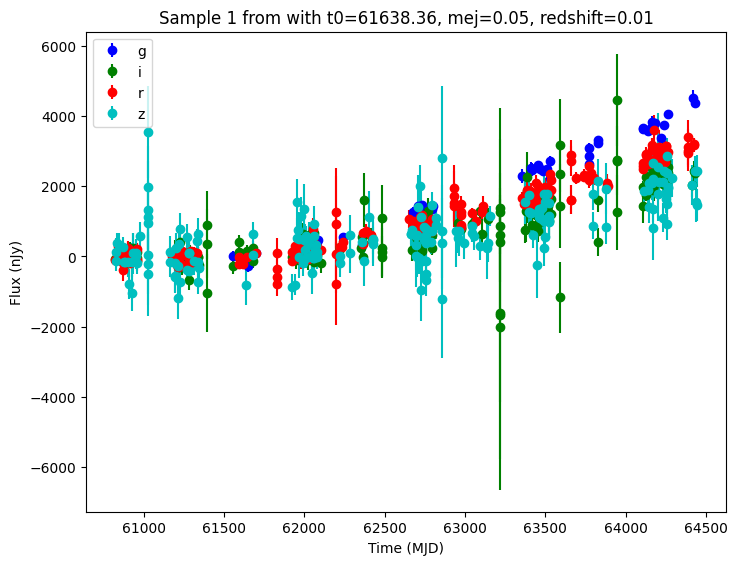

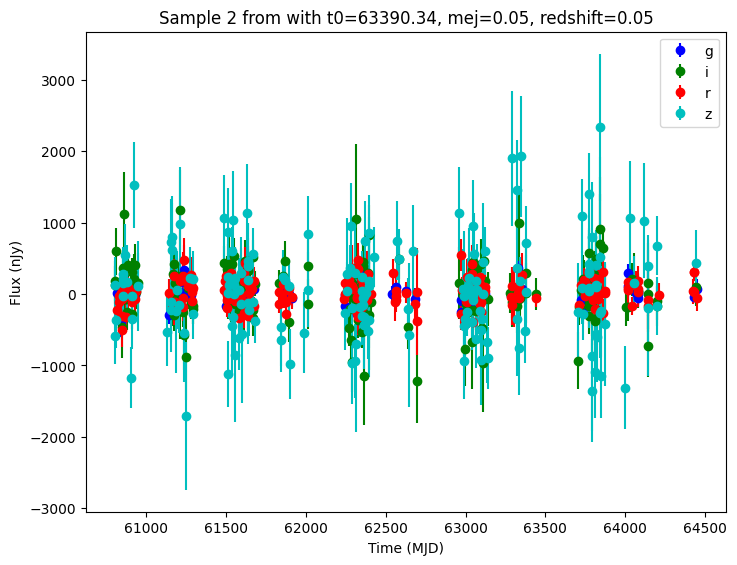

In [7]:
for idx in range(3):
    # Extract the row for this object.
    lc = lightcurves.loc[idx]

    if lc["nobs"] == 0:
        continue

    # Unpack the nested columns (filters, mjd, flux, and flux error).
    lc_filters = np.asarray(lc["lightcurve"]["filter"], dtype=str)
    lc_mjd = np.asarray(lc["lightcurve"]["mjd"], dtype=float)
    lc_flux = np.asarray(lc["lightcurve"]["flux"], dtype=float)
    lc_fluxerr = np.asarray(lc["lightcurve"]["fluxerr"], dtype=float)

    # Get information about the sampled parameter values for the plot's title.
    t0 = lc["params"]["source.t0"]
    mej = lc["params"]["source.mej"]
    redshift = lc["params"]["source.redshift"]

    # Plot the lightcurves.
    plot_lightcurves(
        fluxes=lc_flux,
        times=lc_mjd,
        fluxerrs=lc_fluxerr,
        filters=lc_filters,
        title=f"Sample {idx} from with t0={t0:.2f}, mej={mej:.2f}, redshift={redshift:.2f}",
    )

## Using Redback Priors

Redback models have the ability to draw their parameters using samples from the `bilby` package. We can either define these priors manually or use one of the many sets of priors that are predefined in the redback package ([more information on redback priors here](https://redback.readthedocs.io/en/latest/priors.html). Now let’s load the predefined priors for the "one_component_kilonova_model".

We can see which parameters are included by printing the list.

In [8]:
priors = get_priors(model="one_component_kilonova_model")
print("Priors: ", priors.keys())

Priors:  dict_keys(['redshift', 'mej', 'vej', 'kappa', 'temperature_floor'])


We can incorporate the priors into the model with a variety of mechanisms. The simplest is to pass them as a `priors` parameter when creating the wrapper node.

In [9]:
source2 = RedbackWrapperModel(
    rb_model,
    priors=priors,
    ra=ra_dec_sampler.ra,  # Set other parameters
    dec=ra_dec_sampler.dec,
    t0=time_sampler,
    node_label="source",
)
lightcurves = simulate_lightcurves(source2, 1, opsim_db, passband_group)

Note the difference between `parameters` and the `priors` argument is how the data is interpreted. The `parameters` argument is a dictionary mapping each parameter name to a TDAstro setter. The `priors` argument assumes a Bilby `PriorDict`.

Users can use a combination of the two methods by passing both a `parameters` and a `priors` argument. If the same parameter is defined in both sources, the `parameters` (TDAstro) value will take precedence.

For example, we could override the sampler for redshift as:

In [10]:
parameters = {
    "redshift": NumpyRandomFunc("uniform", low=0.0, high=0.1),  # This is used
}

source3 = RedbackWrapperModel(
    rb_model,
    priors=priors,  # All values except redshift are used
    parameters=parameters,  # Overrides redshift
    ra=ra_dec_sampler.ra,  # Set other parameters
    dec=ra_dec_sampler.dec,
    t0=time_sampler,
    node_label="source",
)

If we generate a single sample from `source3` and look at the etire graph state, we see that the redshift parameters come from the numpy node instead of the bilby prior.

In [11]:
print(source3.sample_parameters(num_samples=1))

ra_dec_sampler:
    ra: [89.13184584]
    dec: [-32.15950853]
    time: 63187.339981110345
source:
    ra: [89.13184584]
    dec: [-32.15950853]
    redshift: 0.013567772107549914
    t0: 61839.04896587486
    distance: None
    mej: 0.03453203417448624
    vej: 0.40396041127881266
    kappa: 2.0074690472785366
    temperature_floor: 101.80300172302724
NumpyRandomFunc:uniform_2:
    low: 0.0
    high: 0.1
    function_node_result: 0.013567772107549914
time_sampler:
    low: 60796.00143922635
    high: 64448.429406568604
    function_node_result: 61839.04896587486
BilbyPriorNode:_non_func_4:
    redshift: 0.037695215851037286
    mej: 0.03453203417448624
    vej: 0.40396041127881266
    kappa: 2.0074690472785366
    temperature_floor: 101.80300172302724
